In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
# set seed before importing keras to change default shuffle argument to false
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, LSTM
from keras.utils import np_utils
from keras.layers import Flatten
import seaborn as sns
import joblib
import tensorflow as tf

In [2]:
df = pd.read_csv('daily-discharge-data2011-Mar2020.csv')
df.head()

,Date,Discharge,Base Flow,Rainfall,TempHigh,TempAvg,TempLow,TempDiff,Evapotranspiration,HumidityMax,HumidityAvg,HumidityMin,WindSpeedMax,WindSpeedAvg,WindSpeedMin
0,5/1/2011,6.03,0.00,32.7542,84.9,78.45,72.0,12.9,77.434770,81.0,65.7,53.0,15.0,8.2,0.0
1,5/2/2011,39.80,2.95,25.8792,86.0,78.55,71.1,14.9,83.307724,88.0,73.1,55.0,17.0,7.9,0.0
2,5/3/2011,24.50,4.49,14.4000,84.9,78.00,71.1,13.8,79.715995,91.0,71.8,51.0,21.0,11.0,0.0
3,5/4/2011,8.93,4.74,27.3792,84.0,78.00,72.0,12.0,74.335548,79.0,66.9,53.0,25.0,16.1,9.0
4,5/5/2011,7.70,4.87,31.3167,84.0,78.50,73.0,11.0,71.542325,79.0,64.0,51.0,22.0,15.2,7.0


In [3]:
df = df.set_index("Date")
df.head()

,Discharge,Base Flow,Rainfall,TempHigh,TempAvg,TempLow,TempDiff,Evapotranspiration,HumidityMax,HumidityAvg,HumidityMin,WindSpeedMax,WindSpeedAvg,WindSpeedMin
Date,,,,,,,,,,,,,,
5/1/2011,6.03,0.00,32.7542,84.9,78.45,72.0,12.9,77.434770,81.0,65.7,53.0,15.0,8.2,0.0
5/2/2011,39.80,2.95,25.8792,86.0,78.55,71.1,14.9,83.307724,88.0,73.1,55.0,17.0,7.9,0.0
5/3/2011,24.50,4.49,14.4000,84.9,78.00,71.1,13.8,79.715995,91.0,71.8,51.0,21.0,11.0,0.0
5/4/2011,8.93,4.74,27.3792,84.0,78.00,72.0,12.0,74.335548,79.0,66.9,53.0,25.0,16.1,9.0
5/5/2011,7.70,4.87,31.3167,84.0,78.50,73.0,11.0,71.542325,79.0,64.0,51.0,22.0,15.2,7.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3502 entries, 5/1/2011 to nan
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Discharge           3256 non-null   float64
 1   Base Flow           3256 non-null   float64
 2   Rainfall            3258 non-null   float64
 3   TempHigh            3258 non-null   float64
 4   TempAvg             3258 non-null   float64
 5   TempLow             3258 non-null   float64
 6   TempDiff            3258 non-null   float64
 7   Evapotranspiration  3258 non-null   float64
 8   HumidityMax         3258 non-null   float64
 9   HumidityAvg         3258 non-null   float64
 10  HumidityMin         3258 non-null   float64
 11  WindSpeedMax        3258 non-null   float64
 12  WindSpeedAvg        3258 non-null   float64
 13  WindSpeedMin        3258 non-null   float64
dtypes: float64(14)
memory usage: 410.4+ KB


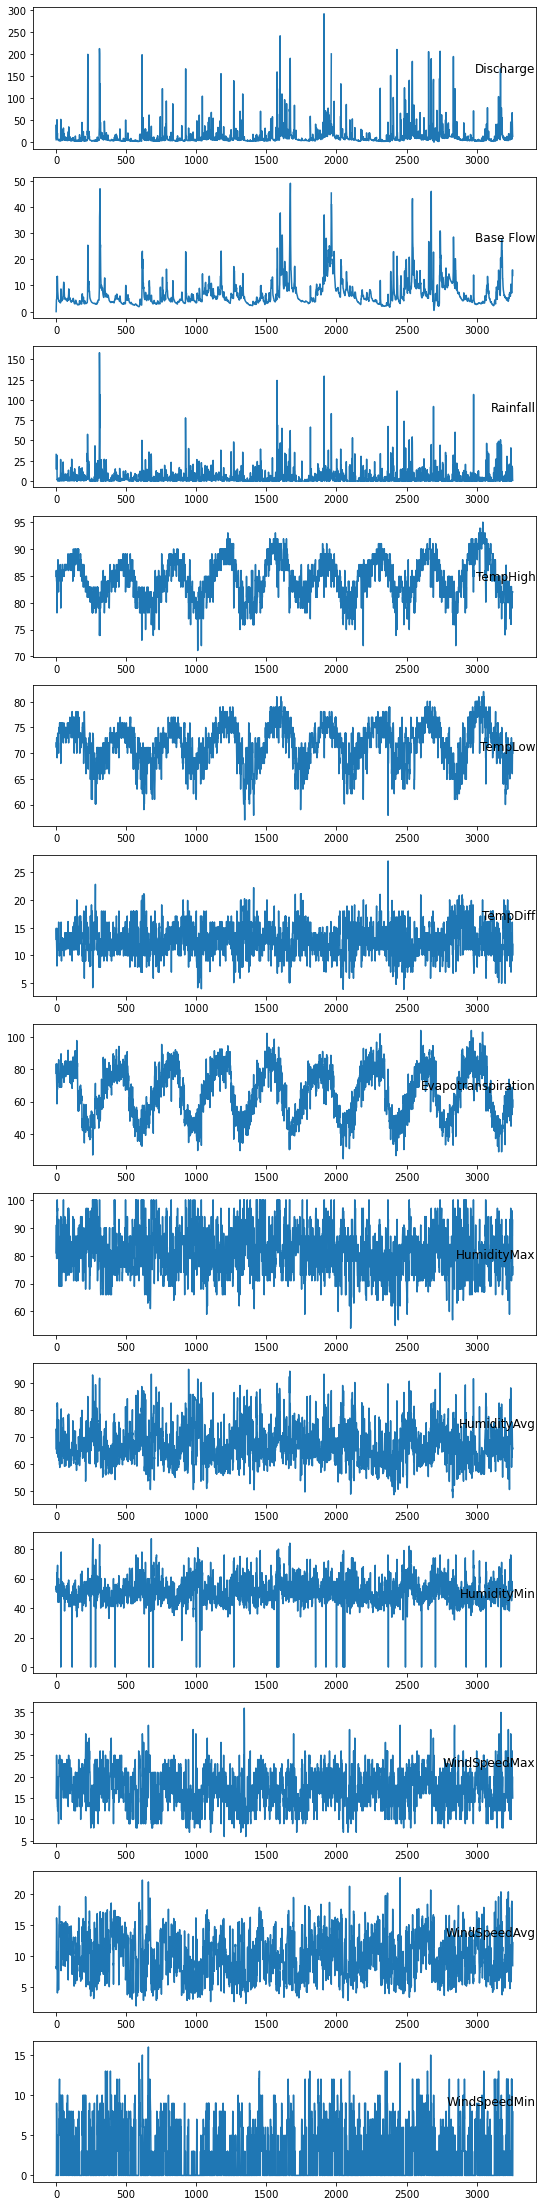

In [5]:
# specify columns to plot
columns = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
i = 1
values = df.values
# define figure object and size
plt.figure(figsize=(9,40))
# plot each column with a for loop
for variable in columns:
     plt.subplot(len(columns), 1, i)
     plt.plot(values[:, variable])
     plt.title(df.columns[variable], y=0.5, loc='right')
     i += 1
plt.show()

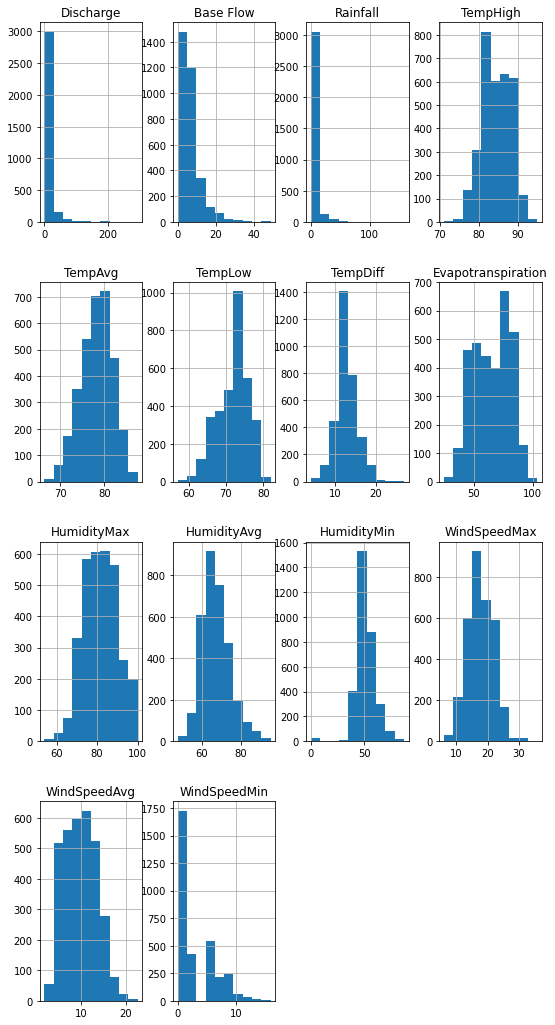

In [6]:
# histograms of the variables
df.hist(figsize=(9,18))
plt.show()

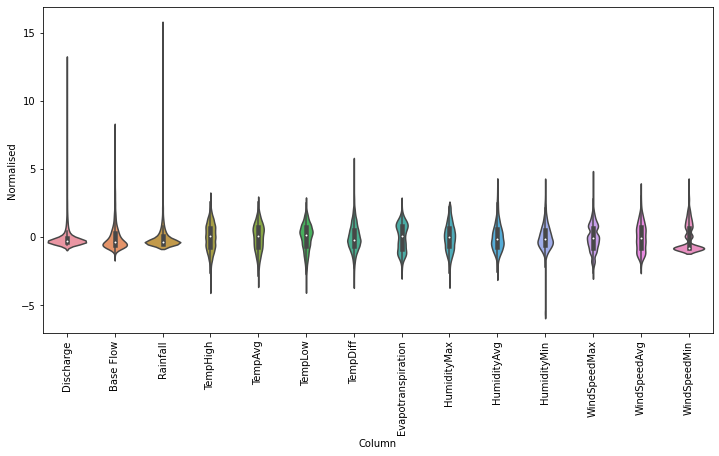

In [7]:
# calculate dataset mean and standard deviation
mean = df.mean()
std = df.std()
# normalise dataset with previously calculated values
df_std = (df - mean) / std
# create violin plot
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [8]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalise each feature variable using Scikit-Learn
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# save scaler for later use
joblib.dump(scaler, 'scaler.gz')
print(scaled)

[[-0.30643806 -1.3153416   2.8130445  ... -0.52538234 -0.4835749
  -0.8186515 ]
 [ 1.2490965  -0.7593928   2.1227372  ... -0.05122841 -0.56761277
  -0.8186515 ]
 [ 0.5443385  -0.46916875  0.9701293  ...  0.8970794   0.30077904
  -0.8186515 ]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


In [9]:
# specify the number of lagged steps and features
backward_steps = 14
n_features = df.shape[1]

In [10]:
#convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
# frame as supervised learning
reframed = series_to_supervised(scaled, backward_steps, 1)

In [12]:
# split into train and test sets
values = reframed.values
threshold = int(0.8 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]

# split into input and outputs
n_obs = backward_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], backward_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], backward_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2578, 196) 2578 (2578,)
(2578, 14, 14) (2578,) (645, 14, 14) (645,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               73216     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 73,345
Trainable params: 73,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
26/26 - 1s - loss: 0.3545 - val_loss: 0.3969
Epoch 2/40
26/26 - 0s - loss: 0.2809 - val_loss: 0.3793
Epoch 3/40
26/26 - 0s - loss: 0.2669 - val_loss: 0.3609
Epoch 4/40
26/26 - 0s - loss: 0.2559 - val_loss: 0.3742
Epoch 5/40
26/26 - 0s - loss: 0.2541 - val_loss: 0.3541
Epoch 6/40
26/26 - 0s - loss: 0.2422 - val_loss: 0.3535
Epoch 7/40
26/26 - 0s - loss: 0.2382 - val_loss: 0.3470
Epoch 8/40
26/26 - 0s - loss: 0.2366 - val_loss: 0.3468
Epoch 9/40
26/26 - 0s - loss: 0.2415 - val_loss: 0.3517
Epoch 10/4

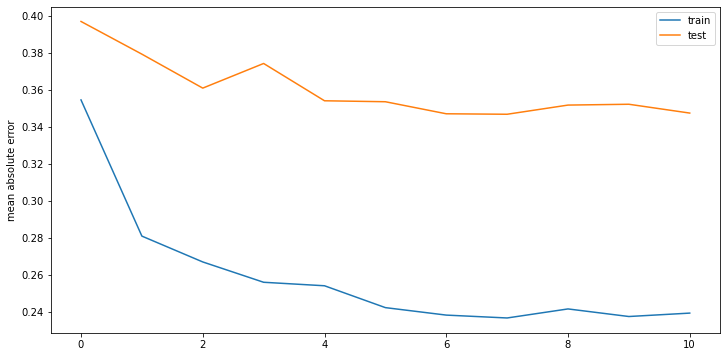

In [13]:
# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# define early stopping parameter
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# fit network
history = model.fit(train_X, train_y, epochs=40, callbacks=[callback], batch_size=72, validation_split=0.3, verbose=2, shuffle=False)
# plot history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], backward_steps*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features - 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features - 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.172


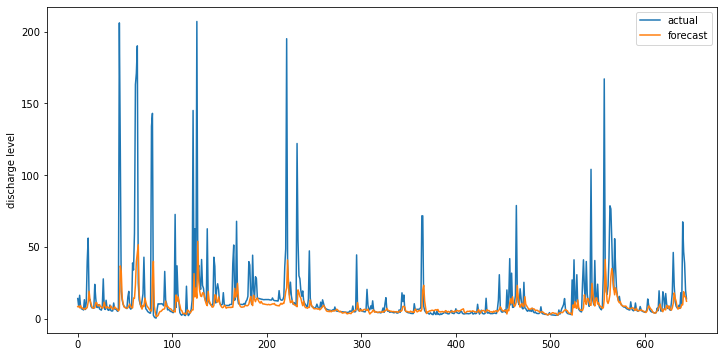

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='forecast')
plt.ylabel('discharge level')
plt.legend()
plt.savefig("plot.jpg")
plt.show()